In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt 
from scipy.io import loadmat, savemat
import seaborn
seaborn.set_style('whitegrid')

In [2]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

In [3]:
from tensorflow import keras
Dense = keras.layers.Dense
Dropout = keras.layers.Dropout
maxnorm = keras.constraints.max_norm
EarlyStopping = keras.callbacks.EarlyStopping

E:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
def create(n_hidden, n_neurons, dropout=None, activation='relu', optimizer='adam'):
    
    model = keras.models.Sequential()
    n_dim = 6 
    model.add(Dense(units=n_neurons, activation=activation, input_dim=n_dim)) # Input shape must be specified for the input layer 
    for _ in range(n_hidden-1):
        if dropout is not None:
            model.add(Dropout(rate=dropout))
        model.add(Dense(units=n_neurons, activation=activation))
            # model.add(Dense(units=n_neurons, activation='relu', kernel_constraint=maxnorm(10)))
    model.add(Dense(units=7, activation='linear')) # Output layer, linear for regression 
    
    model.compile(loss='mean_squared_error', optimizer=optimizer) # adam proved much more useful than sgd
    return model 


# Uncertain Initial Altitude
Train a network exclusively on initial altitude for all outputs

In [5]:
X = []
Y = []
for file in os.listdir("./data/mae278/alt_sweep_fixed"):
    if not file.endswith('.mat'):
        continue
    data = loadmat("./data/mae278/alt_sweep_fixed/"+file, squeeze_me=True)
    x = data['state']
    L = data['costate']
    y = L[0]
#     y = np.append(y, data['time'][-1])
    
    X.append(x[0,2]) # initial altitude
    Y.append(y)
X = np.array(X)
Y = np.array(Y)
  

input_scaler = StandardScaler()
output_scaler = StandardScaler()

Xs = input_scaler.fit_transform(X.reshape(-1, 1))
Ys = output_scaler.fit_transform(Y)
print(np.shape(Xs))
print(np.shape(Ys))  

(101, 1)
(101, 7)


In [26]:
model = keras.models.Sequential()
n_dim = 1 
n_neurons = 50
model.add(Dense(units=n_neurons, activation='relu', input_dim=n_dim)) # Input shape must be specified for the input layer 
# model.add(Dropout(rate=0.1))
model.add(Dense(units=n_neurons, activation='relu'))
model.add(Dropout(rate=0.1))
model.add(Dense(units=n_neurons, activation='relu'))
model.add(Dropout(rate=0.1))
model.add(Dense(units=n_neurons, activation='relu'))
model.add(Dropout(rate=0.1))
model.add(Dense(units=n_neurons, activation='relu'))
model.add(Dense(units=7, activation='linear')) # Output layer, linear for regression 
model.compile(loss='mean_squared_error', optimizer='adam') # adam proved much more useful than sgd
history = model.fit(Xs, Ys, epochs=500, verbose=False, validation_split=0.4)

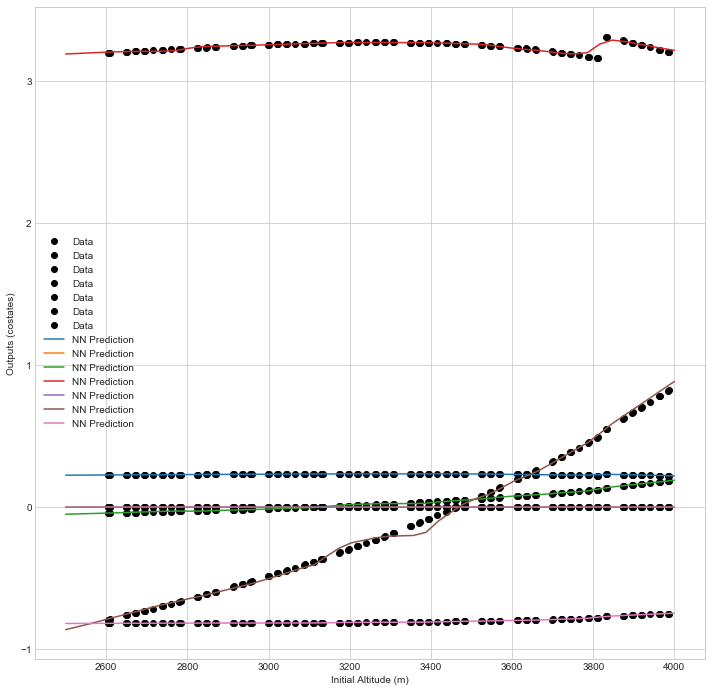

In [27]:
X_test = np.linspace(2500, 4000)
X_test_scaled = input_scaler.transform(X_test[:,None])
y_test_scaled = model.predict(X_test_scaled)
y_test = output_scaler.inverse_transform(y_test_scaled)

plt.figure(figsize=(12,12))
plt.plot(X, Y, 'ko',label='Data')
plt.plot(X_test, y_test,label='NN Prediction')
plt.xlabel('Initial Altitude (m)')
plt.ylabel('Outputs (costates)')
plt.legend()

## Uncertainty in initial position and velocity
Now consider the full problem where the entire initial state $\in\mathbb{R}^6$ (except the mass of the vehicle) can vary within a hyper-rectangle given by:

- Initial range to target $\in[-4200, -2800]$ m
- Initial crossrange to target $\in[-2000, -2000]$ m
- Initial altitude $\in[2600, 4000]$ m
- Initial downrange velocity $\in[585, 725]$ m/s
- Initial crossrange velocity $\in[-100, 100]$ m/s
- Initial vertical velocity $\in[-310, -230]$ m/s


In [75]:
load_dir = "./data/mae278/"
X = []
Y = []
for file in os.listdir(load_dir):
    if not file.endswith('.mat'):
        continue
    data = loadmat(load_dir+file, squeeze_me=True)
    try:
        x = data['state'][0]
        y = data['costate'][0]
    except:
        continue
    if np.abs(y).max() > 15:
        continue
    X.append(x) 
    Y.append(y)
    
X = np.array(X)
Y = np.array(Y)
print(X.shape)
print(Y.shape)
print(Y.max())

(9990, 7)
(9990, 7)
14.336711553392796


In [76]:
savemat("./data/mae278/training.mat", {'x':X,'y':Y})

In [5]:
training = loadmat("./data/mae278/training.mat")
X = training['x']
Y = training['y']

input_scaler = StandardScaler()
output_scaler = StandardScaler()

Xs = input_scaler.fit_transform(X[:,:6])
Ys = output_scaler.fit_transform(Y)
print(np.shape(Xs))
print(np.shape(Ys))  

(9990, 6)
(9990, 7)


In [ ]:
model = create(2, 300, dropout=None)
ES = EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=0, mode='auto')
history = model.fit(Xs, Ys, epochs=500, verbose=True, validation_split=0.15, callbacks=[ES], batch_size=50)

#val loss 0.003, create(5, 20, dropout=None), patience=30, split=0.1, batch=10
#val loss 0.0023, create(2, 50, dropout=None), patience=30, split=0.1, batch=50
#val loss 0.0012, create(2, 500, dropout=None), patience=30, split=0.1, batch=50


In [8]:
# hyper optimization
ES = EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=0, mode='auto')

values = {}

for dr in [None, 0.2, 0.5]:
    for nodes in [500]:
        for layers in [2,3]:
            model = create(layers, nodes, dropout=dr)
            history = model.fit(Xs, Ys, epochs=500, verbose=False, validation_split=0.15, callbacks=[ES], batch_size=50)
            values[(layers,nodes,dr)] = np.min(history.history['val_loss'])

In [9]:
print(values)

{(2, 500, None): 0.0010795940761454403, (3, 500, None): 0.0010308921076183403, (2, 500, 0.2): 0.0024448058521654645, (3, 500, 0.2): 0.005184177155659259, (2, 500, 0.5): 0.005382678948971552, (3, 500, 0.5): 0.00925766410811831}


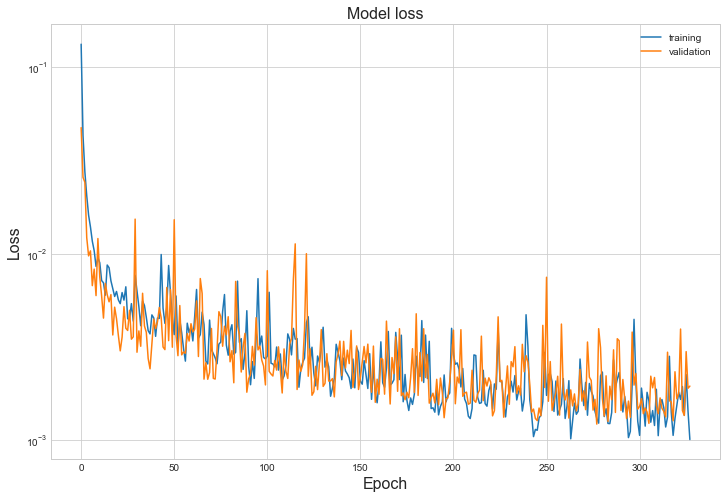

In [16]:
plt.figure(figsize=(12,8))
plt.semilogy(history.history['loss'])
plt.semilogy(history.history['val_loss'])
plt.title('Model loss',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.xlabel('Epoch',fontsize=16)
plt.legend(['training', 'validation'], loc='upper right')
plt.savefig("./data/mae278/images/training.png", bbox_inches='tight')
plt.show()

In [22]:
test = loadmat("./data/mae278/test.mat")
Xtest = test['x']
Ytest = test['y']
print(np.linalg.norm(Ytest,np.inf))
Xs_test = input_scaler.transform(Xtest[:,:6])
Ys_predict = model.predict(Xs_test)
lambda0 = output_scaler.inverse_transform(Ys_predict)
err = np.linalg.norm(lambda0-Ytest, np.inf, axis=0)
print(err)

15.468795028240502
[0.03788948 0.02796409 0.01489687 0.57163631 0.21237164 0.11516553
 0.0295007 ]


### Monte Carlo of NN-Controller

In [18]:
from scipy.integrate import odeint 

# These are closed loop dynamics that depend on the initial costate 
def dynamics(x, t, l0):
    # Problem constants
    Isp = 290;
    g0 = 9.81;
    ve = Isp*g0;
    Tmax = 70*8500
    Tmin = 40*8500
    
    # States being integrated
    r = x[0:3]
    v = x[3:6]
    m = x[6]
    lm = x[7] # Mass costate 
    
    # Costates
    lr = l0[0:3]
    lv0 = l0[3:6]
    lv = lv0 - lr*t
    u = -lv/np.linalg.norm(lv) # Optimal thrust direction
    
    # Optimal thrust magnitude
    S = -lm/ve + np.dot(lv, u)/m
    if S < 0:
        T = Tmax
    else:
        T = Tmin
    
    # State derivatives
    g = np.array([0,0,3.71])
    dx = np.empty(x.shape)     
    dx[0:3] = v
    dx[3:6] = T*u/m - g
    dx[6] = -T/ve    
    dx[7] = T*np.dot(lv, u)/m**2
    return dx


def solve(x0, l0):

    x0 = np.append(x0, l0[-1])
    tf=16
    t = np.linspace(0,tf)
    X = odeint(dynamics, x0, t, args=(l0,))
    miss = np.linalg.norm(X[-1,:3])
    vf = np.linalg.norm(X[-1,3:6])
    prop = X[0,6]-X[-1,6]
    return miss, vf, prop

def ecdf(x):
    x = np.sort(x[:])
    y = np.arange(1,x.size+1)/x.size
    plt.step(x,y)

In [23]:
sol = np.array([solve(x,y) for x,y in zip(Xtest,Ytest)])
print(sol.shape)

(1019, 3)


In [19]:
# sol_train = np.array([solve(x,y) for x,y in zip(X,Y)])
# print(sol_train.shape)
# vf = sol_train.T[1]
# sol_train = sol_train[vf<8.3]
# savemat('./data/mae278/training_solutions.mat',{'sol':sol_train})
sol_train = loadmat('./data/mae278/training_solutions.mat')['sol']



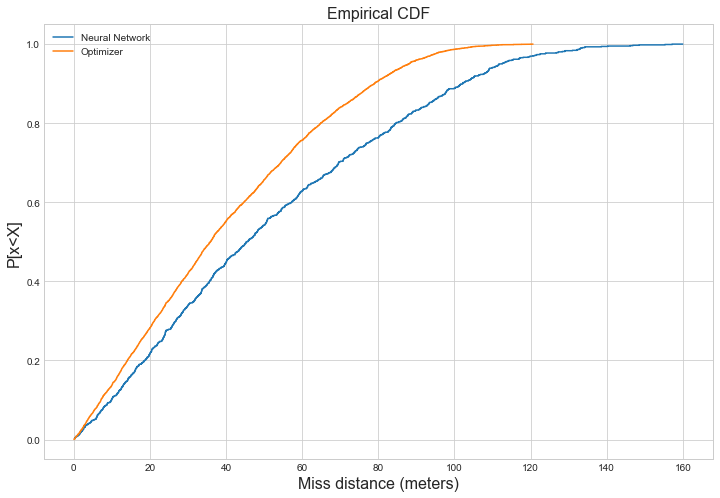

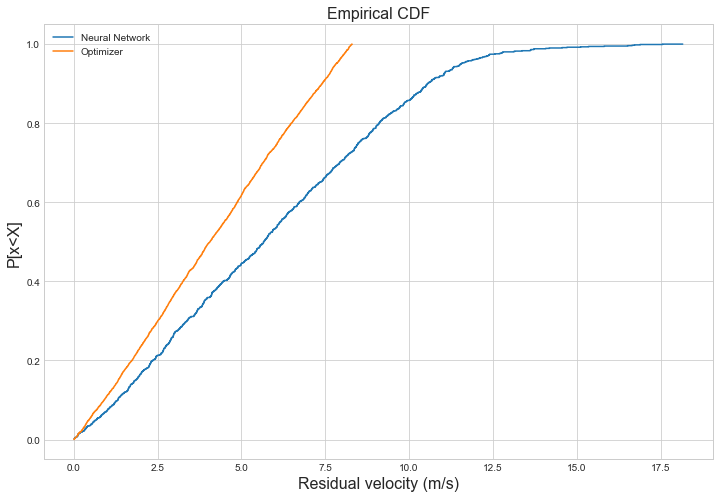

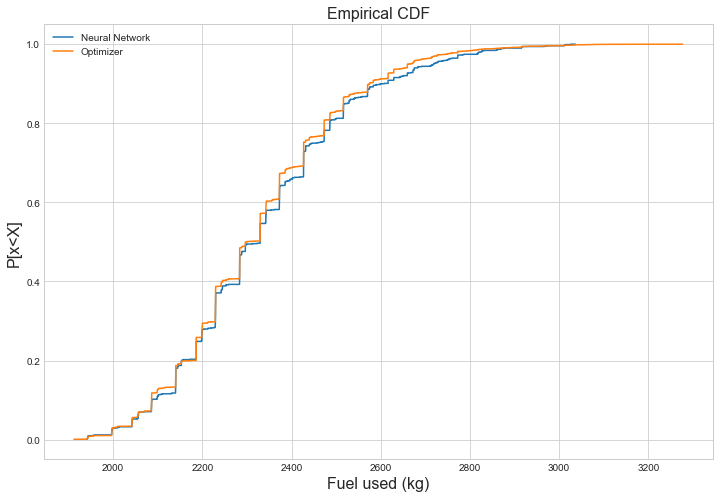

In [24]:
legend = ('Neural Network', 'Optimizer')
figsize = (12,8)
fontsize=16

plt.figure(figsize=figsize)
ecdf(sol.T[0])
ecdf(sol_train.T[0])
plt.xlabel('Miss distance (meters)', fontsize=fontsize)
plt.legend(legend)
plt.title('Empirical CDF', fontsize=fontsize)
plt.ylabel("P[x<X]", fontsize=fontsize)
plt.savefig("./data/mae278/images/missdistance.png", bbox_inches='tight')


plt.figure(figsize=figsize)
ecdf(sol.T[1])
ecdf(sol_train.T[1])
plt.xlabel('Residual velocity (m/s)', fontsize=fontsize)
plt.legend(legend)
plt.title('Empirical CDF', fontsize=fontsize)
plt.ylabel("P[x<X]", fontsize=fontsize)
plt.savefig("./data/mae278/images/velocity.png", bbox_inches='tight')


plt.figure(figsize=figsize)
ecdf(sol.T[2])
ecdf(sol_train.T[2])
plt.xlabel('Fuel used (kg)', fontsize=fontsize)
plt.legend(legend)
plt.title('Empirical CDF', fontsize=fontsize)
plt.ylabel("P[x<X]", fontsize=fontsize)
plt.savefig("./data/mae278/images/fuel.png", bbox_inches='tight')


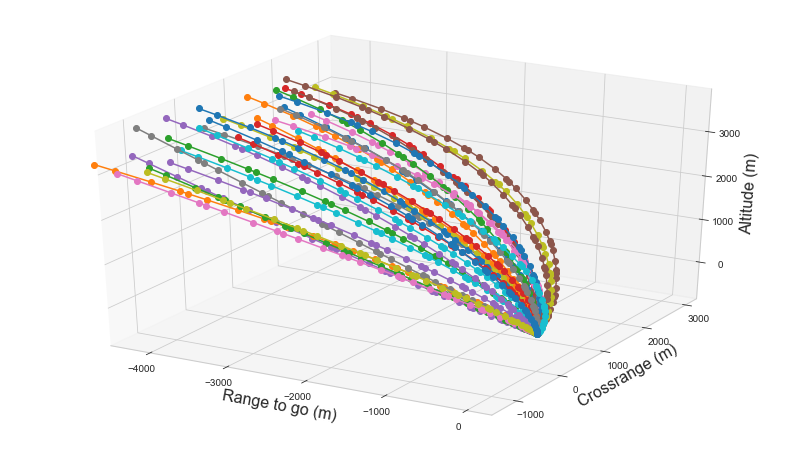

In [26]:
from EntryGuidance.TrajPlot import TrajPlot
load_dir = "./data/mae278/test/"
plt.figure(1, figsize=(14,8))

mf = []
i = 0
for file in os.listdir(load_dir):
    if not file.endswith('.mat'):
        continue
    data = loadmat(load_dir+file, squeeze_me=True)
    x = data['state']
    mf.append(data['state'][0,-1]-data['state'][-1,-1])
    if np.max(x.T[0])<3:
        TrajPlot(*(x.T[0:3]), figNum=1, ground=False, lineSpec='o-')
        i += 1
    if i > 30:
        break
        
plt.xlabel('Range to go (m)', fontsize=fontsize)
plt.ylabel('Crossrange (m)', fontsize=fontsize)
plt.gca().set_zlabel('Altitude (m)', fontsize=fontsize)
plt.savefig("./data/mae278/images/traj.png", bbox_inches=tight)
plt.show()